In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
!pip install xlrd 
!pip install openpyxl
 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
df = pd.read_excel(r'C:\Users\Админ\Downloads\car_market_2023_cleaned.xls')


In [4]:
df.columns


Index(['Brand', 'Year', 'Model', 'UsedOrNew', 'Transmission', 'EngineCapacity',
       'DriveType', 'FuelType', 'FuelConsumption', 'Kilometres',
       'ColourExtInt', 'Location', 'Cylinders', 'BodyType', 'Doors', 'Seats',
       'Price', 'City', 'State'],
      dtype='object')

In [5]:

df = df.dropna()


df = df.reset_index(drop=True)

# Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest
columns_to_use = ['Year', 'EngineCapacity', 'FuelConsumption', 'Kilometres', 'Price']
X = df[columns_to_use]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


iso_forest = IsolationForest(contamination=0.1, random_state=42)  
iso_forest.fit(X_scaled)
df['Anomaly_IF'] = iso_forest.predict(X_scaled)  
df.head()

,Brand,Year,Model,UsedOrNew,Transmission,EngineCapacity,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,Cylinders,BodyType,Doors,Seats,Price,City,State,Anomaly_IF
0,Ssangyong,2022.0,Rexton,DEMO,Automatic,2.2,AWD,Diesel,8.7,5595.0,White / Black,"Caringbah, NSW",2.0,SUV,4.0,7.0,51990.0,Caringbah,NSW,1
1,MG,2022.0,MG3,USED,Automatic,1.5,Front,Premium,6.7,16.0,Black / Black,"Brookvale, NSW",1.0,Hatchback,5.0,5.0,19990.0,Brookvale,NSW,1
2,BMW,2022.0,430I,USED,Automatic,2.0,Rear,Premium,6.6,8472.0,Grey / White,"Sylvania, NSW",2.0,Coupe,2.0,4.0,108988.0,Sylvania,NSW,-1
3,Mercedes-Benz,2011.0,E500,USED,Automatic,5.5,Rear,Premium,11.0,136517.0,White / Brown,"Mount Druitt, NSW",5.0,Coupe,2.0,4.0,32990.0,Mount Druitt,NSW,-1
4,Renault,2022.0,Arkana,USED,Automatic,1.3,Front,Unleaded,6.0,1035.0,Grey / Black,"Castle Hill, NSW",1.0,SUV,4.0,5.0,34990.0,Castle Hill,NSW,1


In [8]:

anomaly_count = (df['Anomaly_IF'] == -1).sum()
print(f"Number of anomalies detected: {anomaly_count}")
anomalies = df[df['Anomaly_IF'] == -1]

anomalous_columns = anomalies.describe(include='all')
print(f"Statistics of anomalous rows by columns:\n{anomalous_columns}")

Number of anomalies detected: 1361
Statistics of anomalous rows by columns:
         Brand         Year        Model UsedOrNew Transmission  \
count     1361  1361.000000         1361      1361         1361   
unique      47          NaN          277         3            2   
top     Toyota          NaN  Landcruiser      USED    Automatic   
freq       338          NaN          194      1270         1080   
mean       NaN  2012.271124          NaN       NaN          NaN   
std        NaN     7.492690          NaN       NaN          NaN   
min        NaN  1985.000000          NaN       NaN          NaN   
25%        NaN  2006.000000          NaN       NaN          NaN   
50%        NaN  2012.000000          NaN       NaN          NaN   
75%        NaN  2019.000000          NaN       NaN          NaN   
max        NaN  2023.000000          NaN       NaN          NaN   

        EngineCapacity DriveType  FuelType  FuelConsumption     Kilometres  \
count      1361.000000      1361      136

# Model Evaluation

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler


In [10]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [11]:

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train_scaled)

y_pred = model.predict(X_test_scaled)
y_pred = [1 if x == 1 else 0 for x in y_pred] 

y_test = np.random.randint(0, 2, size=len(X_test))  


In [12]:

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Precision: 0.51
Recall: 0.91
F1-score: 0.65


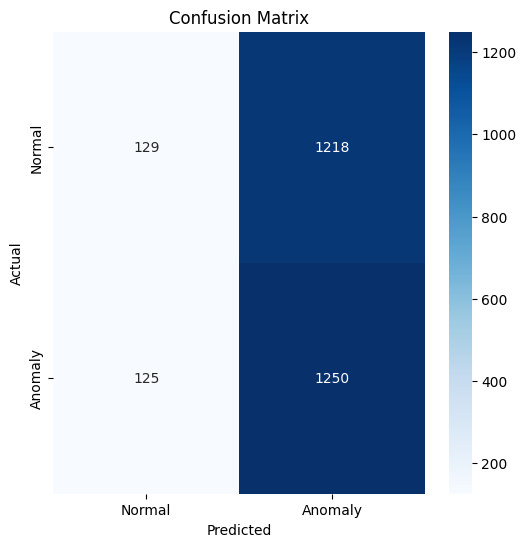

In [13]:


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


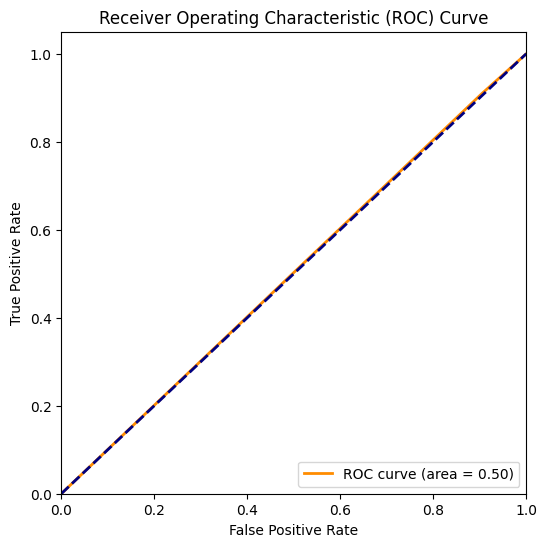

In [14]:


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Visualization

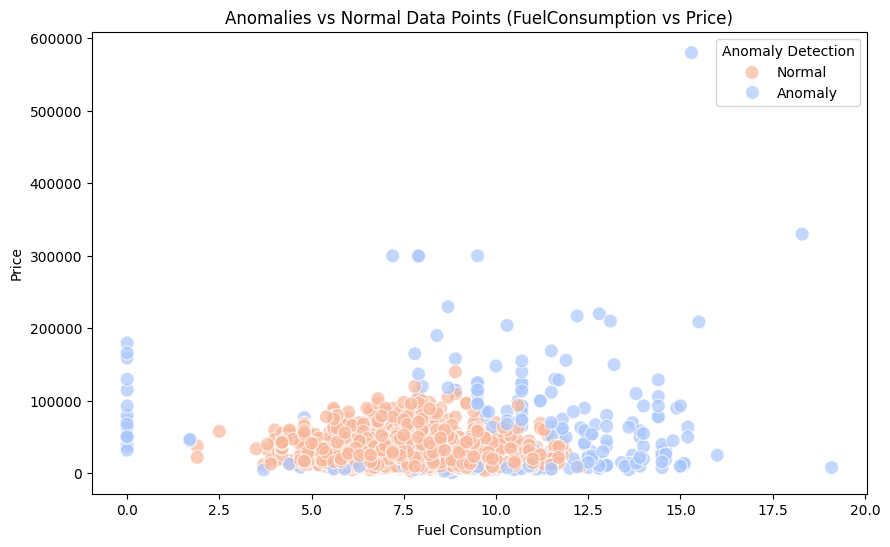

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['FuelConsumption'], y=X_test['Price'], hue=y_pred, palette='coolwarm', s=100, alpha=0.7)
plt.title('Anomalies vs Normal Data Points (FuelConsumption vs Price)')
plt.xlabel('Fuel Consumption')
plt.ylabel('Price')
plt.legend(title='Anomaly Detection', loc='upper right', labels=['Normal', 'Anomaly'])
plt.show()
